<a href="https://colab.research.google.com/github/JaroldEnderez/DragonPay-Testing/blob/main/Yet_another_copy_of_Yet_another_copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from openai import OpenAI
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import time
import seaborn as sns

from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
from google.colab import files

uploaded = files.upload()

Saving NRC-Emotion-Lexicon-Wordlevel-v0.92.txt to NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
Saving test.csv to test.csv
Saving training.csv to training.csv
Saving validation.csv to validation.csv


In [ ]:
from google.colab import files

uploaded = files.upload()

KeyboardInterrupt: 

In [3]:

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')
val_df = pd.read_csv('validation.csv')

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [4]:
class BERTClassifier(nn.Module):
    def __init__(self, nrc_feature_dim, output_dim):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size + nrc_feature_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask, nrc_features, token_type_ids=None): # Add token_type_ids with default value None
        # Pass through BERT model
        # If token_type_ids is provided, use it; otherwise, let BERT use its default
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        bert_embeddings = outputs.last_hidden_state[:, 0, :]  # Take the embedding of [CLS] token

        # Concatenate BERT embeddings with NRC features
        combined_features = torch.cat((bert_embeddings, nrc_features), dim=1)

        # Feed into classifier
        combined_features = self.dropout(combined_features)
        output = self.fc(combined_features)
        return output

In [5]:
def load_nrc_lexicon(filepath):
    nrc_lexicon = {}
    with open(filepath, 'r') as file:
        for line in file:
            word, emotion, association = line.strip().split('\t')
            if word not in nrc_lexicon:
                nrc_lexicon[word] = {}
            nrc_lexicon[word][emotion] = int(association)
            # Add word variations
            if word.endswith('ing'):
                base = word[:-3]
                nrc_lexicon[base] = nrc_lexicon[word]
            elif word.endswith('ed'):
                base = word[:-2]
                nrc_lexicon[base] = nrc_lexicon[word]
    return nrc_lexicon

In [6]:
# Calculate NRC features
def calculate_nrc_features(passages, nrc_lexicon, emotions):
    nrc_features = []
    for text in passages:
        features = [0] * len(emotions)
        words = text.split()
        for word in words:
            if word in nrc_lexicon:
                for i, emotion in enumerate(emotions):
                    features[i] += nrc_lexicon[word].get(emotion, 0)
        nrc_features.append(features)
    return nrc_features

In [7]:
def prepare_data(passages, nrc_lexicon, emotions, tokenizer, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Get device
    # embeddings = []
    nrc_features = []
    attention_masks = []
    input_ids_list = []

    # Move model to the device before any operations
    model.to(device)

    # Tokenize all passages at once to get the maximum sequence length
    encoded_inputs = tokenizer(
        passages, padding=True, truncation=True, return_tensors='pt', max_length=256
    )
    max_seq_length = encoded_inputs['input_ids'].shape[1]

    for i in range(0, len(passages), batch_size):
        batch = passages[i : i + batch_size]

        # Slice the pre-tokenized inputs for the current batch
        batch_input_ids = encoded_inputs['input_ids'][i : i + batch_size].to(
            device
        )  # Move to device
        batch_attention_mask = encoded_inputs['attention_mask'][i : i + batch_size].to(
            device
        )  # Move to device

        # Add input_ids to the list
        input_ids_list.append(batch_input_ids)

        batch_nrc_features = calculate_nrc_features(batch, nrc_lexicon, emotions)
        nrc_features.append(
            torch.tensor(batch_nrc_features, dtype=torch.float32).to(device)
        )  # Move to device

        attention_masks.append(batch_attention_mask)

    # Convert lists to tensors
    input_ids = torch.cat(input_ids_list, dim=0)  # Use cat for input_ids
    attention_masks = torch.cat(attention_masks, dim=0)  # Use cat for attention masks
    nrc_features = torch.cat(nrc_features, dim=0)

    return input_ids, attention_masks, nrc_features  # Return input_ids instead of embeddings

In [8]:
import pandas as pd

train_df = pd.read_csv('training.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

# Use only a fraction of training data (e.g., 50%)

# Extract text and labels
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()


In [9]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = np.log1p(class_weights)  # Apply log1p instead of sqrt

# Convert to tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Using device: cuda


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def train_model(model, train_data, val_data, epochs=3, batch_size=8, lr=1e-5, patience=2):
    """
    Trains the model with early stopping and prints per-epoch metrics.

    Args:
        model: The model to train.
        train_data: Training data.
        val_data: Validation data.
        epochs: Number of training epochs.
        batch_size: Batch size.
        lr: Learning rate.
        patience: Number of epochs to wait for improvement before early stopping.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to the device
    model.to(device)

    train_embeddings, train_attention_masks, train_nrc_features = train_data
    val_embeddings, val_attention_masks, val_nrc_features = val_data

    criterion = nn.CrossEntropyLoss(weight=class_weights)  # Assuming class_weights is defined
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()

        # Process data in batches
        for i in range(0, len(train_texts), batch_size):  # Assuming train_texts is defined

            batch_texts = train_texts[i : i + batch_size]
            batch_labels = train_labels[i : i + batch_size]  # Assuming train_labels is defined
            batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)

            # Tokenize and prepare data for the batch
            encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=256)  # Assuming tokenizer is defined
            input_ids = encoded_inputs['input_ids'].to(device)
            attention_mask = encoded_inputs['attention_mask'].to(device)
            # Create token_type_ids filled with zeros
            token_type_ids = torch.zeros_like(input_ids, dtype=torch.long, device=device)
            nrc_features = torch.tensor(calculate_nrc_features(batch_texts, nrc_lexicon, emotions), dtype=torch.float32).to(device)  # Assuming calculate_nrc_features, nrc_lexicon, emotions are defined

            optimizer.zero_grad()

            # Pass token_type_ids to the model
            outputs = model(input_ids, attention_mask, nrc_features, token_type_ids=token_type_ids)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        # Validation after each epoch
        model.eval()
        with torch.no_grad():
            # Calculate validation loss
            # Pass token_type_ids to the model (filled with zeros for validation as well)
            val_token_type_ids = torch.zeros_like(val_embeddings, dtype=torch.long, device=device)
            val_outputs = model(val_embeddings, val_attention_masks, val_nrc_features, token_type_ids=val_token_type_ids)
            val_loss = criterion(val_outputs, torch.tensor(val_labels, dtype=torch.long).to(device))  # Assuming val_labels is defined

            # Calculate and print metrics
            val_predictions = torch.argmax(val_outputs, dim=1).cpu().numpy()
            accuracy = accuracy_score(val_labels, val_predictions)
            f1 = f1_score(val_labels, val_predictions, average='weighted')
            recall = recall_score(val_labels, val_predictions, average='weighted')
            precision = precision_score(val_labels, val_predictions, average='weighted')  # Calculate precision

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}")
            print(f"  Validation Accuracy: {accuracy:.4f}")
            print(f"  Validation F1 Score: {f1:.4f}")
            print(f"  Validation Recall: {recall:.4f}")
            print(f"  Validation Precision: {precision:.4f}")  # Print precision
            # Add other metrics as needed (e.g., precision, etc.)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

    return model

In [11]:
def freeze_bert_layers(model, freeze_until=6):
    for name, param in model.bert.named_parameters():
        layer_num = int(name.split(".")[2]) if "encoder.layer" in name else None
        if layer_num is not None and layer_num < freeze_until:
            param.requires_grad = False  # Freeze layers
    print(f"✅ Frozen first {freeze_until} layers of BERT.")


In [23]:
import random
import math

# Rename test data to 'train'
train_data_renamed = (
    test_data[0],  # input_ids
    test_data[1],  # attention_mask
    test_data[2]   # nrc_features
)

train_labels_renamed = test_labels  # Use test labels as renamed train labels

# Calculate the number of repetitions (round to nearest integer)
# Ensure the result is smaller than the test dataset size
repetitions = math.ceil(len(train_labels_renamed) * 4.5 / len(test_labels))
# Limit repetitions to a maximum of 4 to prevent exceeding test dataset size
repetitions = min(repetitions, 8)

# Increase the size of the dataset by repeating it using calculated repetitions
training_data = (
    torch.cat([train_data_renamed[0]] * repetitions),
    torch.cat([train_data_renamed[1]] * repetitions),
    torch.cat([train_data_renamed[2]] * repetitions)
)

# Repeat the labels accordingly
training_labels = train_labels_renamed * repetitions


In [13]:
def evaluate_model(model, data, labels, tokenizer, batch_size=8):  # Add batch_size parameter
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    input_ids, attention_mask, nrc_features = data  # Unpack the data tuple

    all_predictions = []
    with torch.no_grad():
        # Process data in batches
        for i in range(0, len(input_ids), batch_size):  # Iterate in batches
            batch_input_ids = input_ids[i : i + batch_size].to(device)
            batch_attention_mask = attention_mask[i : i + batch_size].to(device)
            batch_nrc_features = nrc_features[i : i + batch_size].to(device)

            # Make predictions for the batch
            batch_predictions = model(input_ids=batch_input_ids,
                                     attention_mask=batch_attention_mask,
                                     nrc_features=batch_nrc_features)
            batch_predictions = torch.argmax(batch_predictions, dim=1).cpu().numpy()
            all_predictions.extend(batch_predictions)  # Extend predictions

    # Evaluate performance
    accuracy = accuracy_score(labels, all_predictions)
    print(f"Accuracy: {accuracy}")
    cm = confusion_matrix(labels, all_predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    print("Classification Report:")
    print(classification_report(labels, all_predictions))

Label 0: 4666 samples
Label 1: 5362 samples
Label 2: 1304 samples
Label 3: 2159 samples
Label 4: 1937 samples
Label 5: 572 samples


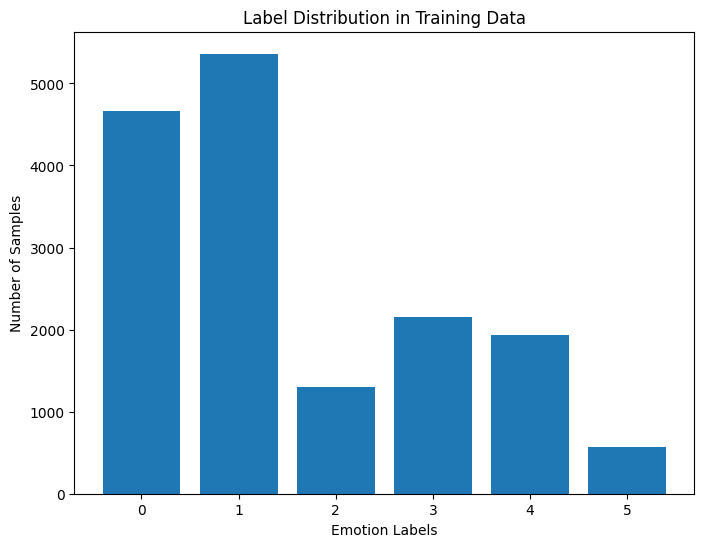

In [14]:
import matplotlib.pyplot as plt
import numpy as np

train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

# Get unique labels and their counts
unique_labels, counts = np.unique(train_labels, return_counts=True)

# Print label distribution
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} samples")

# Create bar graph
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(unique_labels, counts)
plt.xlabel("Emotion Labels")
plt.ylabel("Number of Samples")
plt.title("Label Distribution in Training Data")
plt.xticks(unique_labels)  # Ensure all labels are displayed on x-axis
plt.show()

In [15]:

import torch
from transformers import AutoTokenizer, AutoModel
from imblearn.over_sampling import SMOTE
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts, batch_size=32):  # Adjust batch size as needed
    """Gets BERT embeddings for a list of texts in batches."""
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Move to CPU immediately
        all_embeddings.extend(embeddings)
        del inputs, outputs, embeddings  # Explicitly delete to free memory
    return np.array(all_embeddings)

# Get BERT embeddings for the training data in batches
train_texts_embeddings = get_bert_embeddings(train_texts)

# Apply SMOTE to the BERT embeddings
oversampler = SMOTE(sampling_strategy={2: 4000, 5: 4000})
train_texts_resampled_embeddings, train_labels_resampled = oversampler.fit_resample(train_texts_embeddings, train_labels)

# Optional: If you need the resampled text data, you can try to get an approximation using cosine similarity:
from sklearn.metrics.pairwise import cosine_similarity

def get_closest_texts(resampled_embeddings, original_embeddings, original_texts):
    resampled_texts = []
    for emb in resampled_embeddings:
        similarities = cosine_similarity(emb.reshape(1, -1), original_embeddings)
        closest_index = np.argmax(similarities)
        resampled_texts.append(original_texts[closest_index])
    return resampled_texts

train_texts_resampled = get_closest_texts(train_texts_resampled_embeddings, train_texts_embeddings, train_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [29]:
# Load NRC lexicon
nrc_lexicon = load_nrc_lexicon("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")  # Load NRC lexicon
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']  # Define emotions

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BERTClassifier(nrc_feature_dim=len(emotions), output_dim=6)  # 6 emotions for classification
model.eval()  # Set to evaluation mode

# Prepare train and validation data
train_data = prepare_data(train_texts, nrc_lexicon, emotions, tokenizer)
val_data = prepare_data(val_texts, nrc_lexicon, emotions, tokenizer)

# Train the model


In [30]:
freeze_bert_layers(model, freeze_until=6)  # Adjust layers as needed

model = train_model(model, train_data, val_data)

# Prepare test data and evaluate the model
test_data = prepare_data(test_texts, nrc_lexicon, emotions, tokenizer)


✅ Frozen first 6 layers of BERT.
Using device: cuda
Epoch 1/3, Loss: 0.0240863598883152, Val Loss: 0.2849600315093994
  Validation Accuracy: 0.9015
  Validation F1 Score: 0.9027
  Validation Recall: 0.9015
  Validation Precision: 0.9070
Epoch 2/3, Loss: 0.013435509987175465, Val Loss: 0.23167037963867188
  Validation Accuracy: 0.9150
  Validation F1 Score: 0.9161
  Validation Recall: 0.9150
  Validation Precision: 0.9199
Epoch 3/3, Loss: 0.01213607657700777, Val Loss: 0.22617091238498688
  Validation Accuracy: 0.9145
  Validation F1 Score: 0.9157
  Validation Recall: 0.9145
  Validation Precision: 0.9198


Accuracy: 0.917
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2905
           1       0.97      0.91      0.94      3475
           2       0.75      0.94      0.83       795
           3       0.91      0.94      0.92      1375
           4       0.87      0.91      0.89      1120
           5       0.74      0.82      0.78       330

    accuracy                           0.92     10000
   macro avg       0.87      0.91      0.88     10000
weighted avg       0.92      0.92      0.92     10000



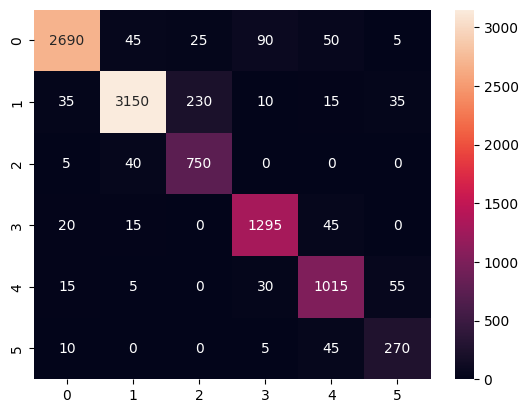

In [31]:
evaluate_model(model, training_data, training_labels, tokenizer)
